<a href="https://colab.research.google.com/github/Neruoy/Vision-based-robotic-grasping-system-using-deep-learning/blob/main/transfer_model_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Thu Jun  3 10:24:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set Up

## Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pandas as pd
import sklearn
import pickle

## Unzip dataset

In [3]:
# !unzip /content/drive/MyDrive/DLOD/train_600.zip

In [4]:
# !unzip /content/drive/MyDrive/DLOD/dataset/dataset.zip

In [5]:
# !unzip /content/drive/MyDrive/DLOD/train_47.zip

In [6]:
# !unzip /content/drive/MyDrive/DLOD/data_531.zip

In [47]:
# SET = '600'
SET = '47'
PICKLE = True

In [8]:
if SET == '600':
  TRAIN_FOLDER = '/content/train_600/train'
if SET == '47':
  TRAIN_FOLDER = '/content/train_47'
train_images_folder = os.path.join(TRAIN_FOLDER, 'images')
train_label_txt_folder = os.path.join(TRAIN_FOLDER, 'label_txt')

In [9]:
TEST_FOLDER = '/content/dataset/test'
test_images_folder = os.path.join(TEST_FOLDER, 'images')

## Set the training and test set

### Functions

In [10]:
def image_path2label_path(path, label_type='txt'):
  if label_type == 'txt':
    if SET == '600':
      label_path = os.path.join(train_label_txt_folder, os.path.basename(path).replace('jpg', 'txt'))
    if SET == '47':
      label_path = os.path.join(train_label_txt_folder, os.path.basename(path).replace('png', 'txt'))
  elif label_type == 'xml':
    label_path = os.path.join(train_label_xml_folder, os.path.basename(path).replace('jpg', 'xml'))
    pass
  else:
    raise Exception('No such label type')
  return label_path

def label_path2label(path, label_type='txt'):
  if label_type == 'txt':
    return np.loadtxt(path)[:4].ravel()

In [50]:
def preprocess_image(image):
  if not PICKLE:
    image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def normalize_label(label, w, h):
  return label / np.array([w, h] * 4)

def invnormalize_label(label, w, h):
  return label * np.array([w, h] * 4)

SyntaxError: ignored

In [12]:
def draw_box(image, label):
  f = plt.figure(figsize=(16, 9))
  img = image
  pt = {}
  for j, i in enumerate(range(0, 8, 2)):
    pt[j + 1] = (int(label[i:i + 1][0]), int(label[i + 1:i + 2][0]))
  cv2.line(img, pt[1], pt[2], (0,0,255), 3)
  cv2.line(img, pt[2], pt[3], (0,0,255), 3)
  cv2.line(img, pt[3], pt[4], (0,0,255), 3)
  cv2.line(img, pt[4], pt[1], (0,0,255), 3)
  plt.imshow(img)

### Pre-prepocessing (match laebls with images)

Get the images paths list and shuffle it.

In [13]:
import random
train_images_paths = [os.path.join(train_images_folder, image) for image in os.listdir(train_images_folder)]
random.shuffle(train_images_paths)

In [14]:
if SET == '600':
  train_images_paths.remove('/content/train_600/train/images/.DS_Store')
if SET == '47':
  train_images_paths.remove('/content/train_47/images/.DS_Store')

Result:

In [15]:
train_images_paths[:5]

['/content/train_47/images/img0406r.png',
 '/content/train_47/images/img0203r.png',
 '/content/train_47/images/img0603r.png',
 '/content/train_47/images/img0405r.png',
 '/content/train_47/images/img0409r.png']

In [16]:
print('Number of iamges: {}'.format(len(train_images_paths)))

Number of iamges: 46


Get the corresponding labels paths list.

In [17]:
train_labels_paths = [image_path2label_path(img_path) for img_path in train_images_paths]

Result:

In [18]:
train_labels_paths[:5]

['/content/train_47/label_txt/img0406r.txt',
 '/content/train_47/label_txt/img0203r.txt',
 '/content/train_47/label_txt/img0603r.txt',
 '/content/train_47/label_txt/img0405r.txt',
 '/content/train_47/label_txt/img0409r.txt']

Get labels from label paths

In [19]:
train_labels = [label_path2label(label_path) for label_path in train_labels_paths]

In [20]:
print('Number of labels: {}'.format(len(train_labels)))

Number of labels: 46


Quick peek

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


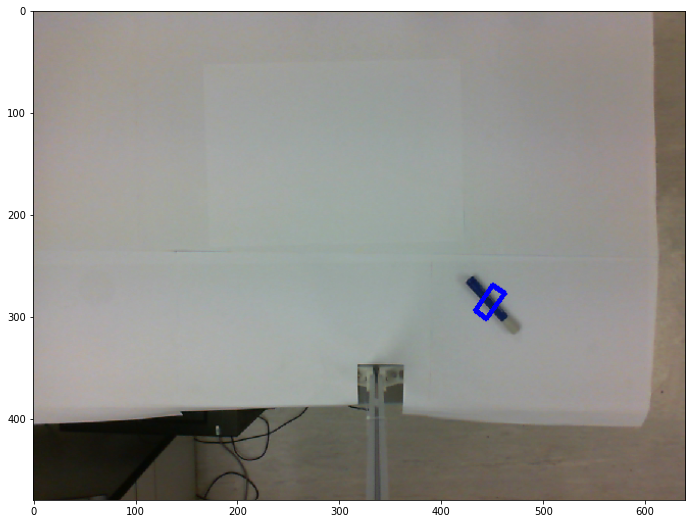

In [21]:
index = 3
image, label = plt.imread(train_images_paths[index]), train_labels[index]
draw_box(image, label)

In [22]:
(HEIGHT, WIDTH, CHANNELS) = image.shape
(HEIGHT, WIDTH, CHANNELS)

(480, 640, 3)

### Load pickle dataset

In [49]:
if PICKLE:
  with open('/content/x_train', 'rb') as file:
    x_train = pickle.load(file)
  with open('/content/y_train', 'rb') as file:
    y_train = pickle.load(file)
  with open('/content/x_val', 'rb') as file:
    x_val = pickle.load(file)
  with open('/content/y_val', 'rb') as file:
    y_val = pickle.load(file)
  with open('/content/x_test', 'rb') as file:
    x_test = pickle.load(file)
  with open('/content/y_test', 'rb') as file:
    y_test = pickle.load(file)
  
  (HEIGHT, WIDTH, CHANNELS) = x_train[1].shape
  print('PICKLE:', (HEIGHT, WIDTH, CHANNELS))

PICKLE: (720, 1280, 3)


### Prepocessing

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

Create images paths dataset

In [24]:
images_paths_ds = tf.data.Dataset.from_tensor_slices(train_images_paths)

Load and prepocess the image then form a images dataset

In [25]:
if not PICKLE:
  images_ds = images_paths_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
else:
  images_ds = tf.data.Dataset.from_tensor_slices(x_train)
  images_ds = images_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

Create labels dataset

In [26]:
labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)

Normalize the labels

In [27]:
normalized_labels_ds = labels_ds.map(lambda label: normalize_label(label, w=WIDTH, h=HEIGHT),
                                     num_parallel_calls=AUTOTUNE)

#### 1. Use numpy array dataset

In [28]:
images = np.array([img for img in images_ds])

In [29]:
images.shape

(46, 224, 224, 3)

In [30]:
labels = np.array([lab for lab in normalized_labels_ds])

In [31]:
labels.shape

(46, 8)

Check inv-normalize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


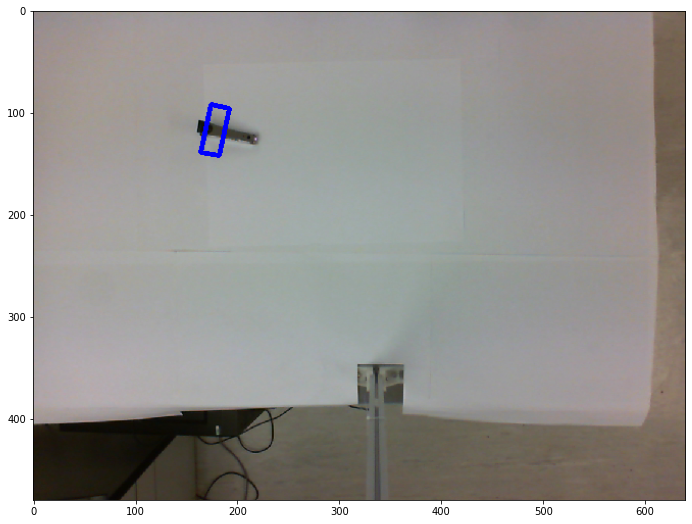

In [32]:
index = 7
image = plt.imread(train_images_paths[index])
label = invnormalize_label(labels[index], w=WIDTH, h=HEIGHT)
draw_box(image, label)

### Creat test set

In [33]:
test_images_paths = [os.path.join(test_images_folder, img) for img in os.listdir(test_images_folder)]
test_images_paths[:5]

['/content/dataset/test/images/img30200r.jpg',
 '/content/dataset/test/images/img10501r.jpg',
 '/content/dataset/test/images/img30300r.jpg',
 '/content/dataset/test/images/img10300r.jpg',
 '/content/dataset/test/images/img10101r.jpg']

In [34]:
test_images_paths.remove('/content/dataset/test/images/.DS_Store')

In [35]:
(HEIGHT_TEST, WIDTH_TEST, CHANNELS_TEST) = plt.imread(test_images_paths[0]).shape
(HEIGHT_TEST, WIDTH_TEST, CHANNELS_TEST)

(720, 1280, 3)

In [36]:
test_images_paths_ds = tf.data.Dataset.from_tensor_slices(test_images_paths)

In [37]:
test_images_ds = test_images_paths_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

With numpy

In [38]:
test_images = np.array([img for img in test_images_ds])

# Model training

## Construct the model

### Base model

In [40]:
base_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3),
                                         include_top=False, weights='imagenet')

In [41]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Add layers

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_1 = tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal')
# hidden_2 = tf.keras.layers.Dense(1024, activation='selu', kernel_initializer='lecun_normal')
# hidden_3 = tf.keras.layers.Dense(256, activation='selu', kernel_initializer='lecun_normal')
prediction_layer = tf.keras.layers.Dense(8)

In [43]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_1(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.AlphaDropout(0.2)(x)
# x = hidden_2(x)
# x = tf.keras.layers.AlphaDropout(0.2)(x)
# x = hidden_3(x)
# x = tf.keras.layers.AlphaDropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1050624   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16392     
Total params: 21,091,400
Trainable params: 1,067,016
Non-trainable params: 20,024,384
_________________________________________

### Compile model

In [45]:
initial_lr = 0.001
optimizer = tf.keras.optimizers.Nadam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='mse')

### Training

In [46]:
run_index = 2
run_logdir = os.path.join(os.curdir, "logs", "run_{:03d}".format(run_index))
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
initial_epochs = 10000
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('vgg19_tf.h5', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=100, monitor='loss', restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=50)
history = model.fit(x_train,
                    y_train, 
                    epochs=initial_epochs, 
                    validation_data=(x_val, y_val),
                    batch_size=128,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/10000


ValueError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
final_model = tf.keras.models.load_model("vgg19_tf.h5")

## Test

In [ ]:
outputs = final_model.predict(images[:5])

In [ ]:
outputs.shape

In [ ]:
pred = [invnormalize_label(label, w=WIDTH, h=HEIGHT) for label in outputs]

In [ ]:
draw_box(plt.imread(train_images_paths[4]), pred[4])